Author: Alexander N. Skvortsov<br>
Linkedin:www.linkedin.com/in/alexander-skvortsov-143790139


#                                  Purpose of this document
In this document theory of GA's will not be discussed as there are plenty of books out there that do it well. The main goal is, by implementing the theory in order to solve a simple optimization problem help some people to understand GA's a little bit better.

(The implementation is in Python)

# **Optimization Problems**
Imagine you have 100 numbered cards (1,2,3,..,100) and you want to split them into 		two baskets, A and B, so that the sum of the card numbers in basket A is S and the 		product of the cards in basket B is P. (S, P integers). The split does not have to be 		equal, so for example you are free to put 80 cards in A and 20 in B.

The issue here is obviously the large number of possible combinations ($ 2 ^{100} $). And there also may not be a precise solution, since S and P can be any integers it is given.


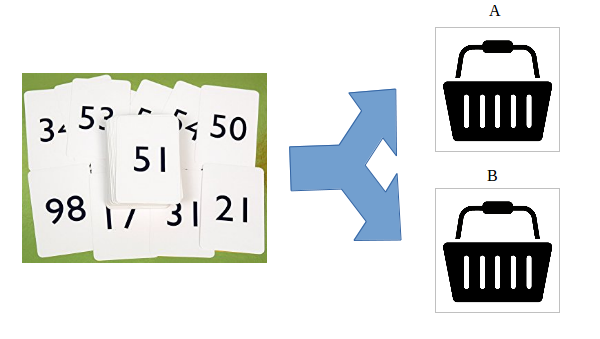

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
PATH = "/home/alexander/Documents/"
Image(filename = PATH + "im1.png", width=800, height=900)

#                                             Genetic Algorithms

A [genetic algorithm](https://en.wikipedia.org/wiki/Genetic_algorithm) (GA) is a metaheuristic inspired by the process of natural selection that belongs to the larger class of evolutionary algorithms (EA). Genetic algorithms are commonly used to generate high-quality solutions to optimization and search problems by relying on bio-inspired operators such as **selection, crossover and mutation**. 



In order to illustrate their functionality and possibilities, in this tutorial, a genetic algorithm is implemented with the operators mentioned above plus an initialization function that solves the optimization problem mentioned above.

# How to solve it using a GA

**Step 1: Represantation**

We have to think how each solution (chromosome) will be represented. For this problem binary represantation will be used. Since there are 100 cards, each chromosome will be constituted of 100 genes (bits) and if the bit at the positon l is 0, then the card number l will go to the summation basket and if it’s 1 to the product basket. 

e.g. 110011...00 → the card numbers 1,2,5,6 will be put into basket B (product), so the product is already p = 1x2x5x6 = 60 and the cards 3,4,99,100 to A, so the summation is already s = 206. And similarly for the other cards.

Let's start by importing some libraries.

In [2]:
import random
import numpy as np
import sys
import matplotlib.pyplot as plt
import math
import operator

**Step 2: Population Initialization**

Each chromosome is considered as a solution. So now we have to produce an initial population, randomly or using some heuristic. For this task  the function: **random_B_initialization()** was implemented. It initializes a population randomly. The arguments you have to provide are: number of genes in chromosomes, size of population (# chromosomes) and (optional) at initialization stage,if you want to have maximum and minimum number of 1’s and 0’s.

In [3]:
# create a random population. the bits argument defines the number of bits (genes) each chromosome will consist of
# popSize will determine the number of chromosomes and 'onesMax' determines the maximum number of ones for each chromosome
def random_B_initialization(population, bits, popSize, onesMin=0, onesMax=0):
    #first we choose randomly how many ones each chromosome will have
    #and then their positions

    if onesMax != 0 and onesMin != 0:
        for ite in range(popSize):
            i = random.randrange(onesMin, onesMax + 1)
            a = random.sample(range(0, bits), i)
            
            for pos in a:
                population[ite, pos] = 1

    elif onesMax != 0:
        for ite in range(popSize):
            i = random.randrange(0, onesMax + 1)
            a = random.sample(range(0, bits), i)
            
            for pos in a:
                population[ite, pos] = 1

    elif onesMin != 0:
        for ite in range(popSize):
            i = random.randrange(onesMin, bits + 1)
            a = random.sample(range(0, bits), i)
            
            for pos in a:
                population[ite, pos] = 1

    else:

        for ite in range(popSize):
            i = random.randrange(0, bits + 1)
            a = random.sample(range(0, bits), i)
            
            for pos in a:
                population[ite, pos] = 1
                
    return population

**Step 3: Evaluation**

The function evaluation() evaluates each solution (chromosome). To “see” how close each one is. The error equation we used is:

				 Εrror = |Ρ - goal_product| + |S - goal_summation| Χ 10 
                
	 
We multiply the summation difference by 10 because small differences in products are much less important than in sums. The reason is that it is much more difficult to find the wanted product because even the slightest difference in some numbers can overshoot the final result.


The fitness function is defined as: $$f(Error) = 1 / (Error+1)$$


In [4]:
def fitness(s, p):
    global want_sum, want_prod
    error = abs(want_prod - p) + abs(want_sum - s) * 10
    return 1 / (error + 1)

In [5]:
def evaluation(population, number_of_chroms):
    global genes
    values = np.zeros((number_of_chroms,1))
    if number_of_chroms == 1:
        sum = 0
        prod = 1
        for j in range(0, genes):
            if population[j] == 0:
                sum += (j + 1)
            else:
                prod *= (j + 1)
        return sum,prod

    else:
        for i in range(0, number_of_chroms):
            sum = 0
            prod = 1
            for j in range(0, genes):
                if population[i, j] == 0:
                    sum += (j + 1)
                else:
                    prod *= (j + 1)

            values[i] = fitness(sum, prod)   
    return values

In [6]:
#the below function returns the average value of all of the population's values at a current epoch
def avgValue(popSize):
    global values
    sum = 0
    for i in values:
        sum += i

    return sum / popSize

**Step 4: Couple Selection**

In order to apply crossover, we first need to have couples (mommy and daddy). There are many methods to do it. The method implemented here is the k-ways tournament selection. The user has just to provide the k argument.

Before proceeding to the programme, below is the logic of how the tournament selection method was implemented. The function that implements it is called tournamentSelection.

    1) Choose how many couples there will be. This is done randomly.

    2) Choose k different chromosomes as men and k different chromosomes as women. This is done by                                       couple_Selection function  

    3) From the chosen "men" and "women", find the "best" man and the "best" woman. This is done by                                                                                                  find_Max_Parent function. In the programme they are referred to as "winners"

    4) Repeat the above steps for i = number of couples.

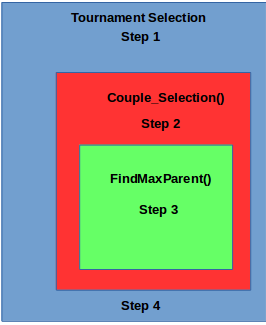

In [7]:
from IPython.display import Image
from IPython.core.display import HTML 
PATH = "/home/alexander/Documents/"
Image(filename = PATH + "im2.png", width=450, height=450)

In [8]:
# findMaxParent will accept a 2 x ways array and will return a 2x1 array. The best parents
# notice that randomCouple array contains the positions of the parents, not their values
def findMaxParent(randomCouple, ways):
    global values
    max1 = randomCouple[0,0]
    max2 = randomCouple[1,0]
    for i in range(1, ways):
        v1 = values[int(max1)]
        v2 = values[int(max2)]
        vTemp1 = values[int(randomCouple[0,i])]
        vTemp2 = values[int(randomCouple[1,i])]

        if(v1<vTemp1):
            max1 = randomCouple[0,i]
        if(v2 < vTemp2):
            max2 = randomCouple[1,i]

    return max1,max2

In [9]:
# coupleSelection chooses randomly #ways different "men" and "women". Then returns 2 people (1x2 array) as a couple
def coupleSelection(popSize, ways):
    
    couple = np.zeros((2, ways))
    temp = np.zeros((1, ways))
    winners = np.zeros((1,2))
    couple[0, :] = random.sample(range(0, popSize), ways) #let's assume that first row is for men and the second for women
    i = 0
    
    while i < ways:
        x = random.randrange(0,popSize)
        if x not in couple[0, :]:
            temp[0,i] = x
            i += 1

    couple[1,:] = temp
    winners = findMaxParent(couple,ways)
    
    return winners

In [10]:
def tournamentSelection(ways, popSize):
    global values, numberOfCouples

    numberOfCouples = random.randrange(1, int(popSize/2) + 1) # here we decide how many couples there will be
    winners = np.zeros((numberOfCouples, 2)) # this array will store the 2 people to cross

    for i in range(0, numberOfCouples):
        winners[i] = coupleSelection(popSize, ways)
    
    return winners

Step 5) **Crossover function**: It takes genes from both parents in order to create the "children"

In [11]:
#crossover function will get 2 people and randomly crossover them (randomly exchange 2,3 or 4 parts)
#pc = probability of crossover
def crossover(couple, genes):
    global population,kids
    parts = random.randrange(2, 5) # this variable will select in how many parts to break each couple
    take = int(genes / parts)
    took = 0
    i = 0 # i will show whether to take from male or female
    dif = genes - took

    kids = np.zeros((2, genes))
    male = population[int(couple[0])].copy()
    female = population[int(couple[1])].copy()

    while dif >= take:
        if i==0: 
            kids[0,took:(took + take)] = female[took:(took + take)]
            kids[1,took:(took + take)] = male[took:(took + take)]
            i = 1

        elif i==1: 
            kids[1,took:(took + take)] = female[took:(took + take)]
            kids[0,took:(took + take)] = male[took:(took + take)]
            i = 0
        took +=take
        dif = genes - took

    if i==0:
        kids[0,took:(took + dif)] = female[took:(took + dif)]
        kids[1,took:(took + dif)] = male[took:(took + dif)]

    elif i==1:
        kids[1,took:(took + dif)] = female[took:(took + dif)]
        kids[0,took:(took + dif)] = male[took:(took + dif)]

    return kids

Step 6) Mutation, 2 types of mutations are implemented and they are chosen randomly each time. 

In [12]:
def mutation(kids, genes):
    muteKind = random.randrange(1, 3) # will choose the kind of mutation
    '''
    1: choose 1 random bit and flip it -> flip mutation
    2: choose 2 random bits and swap them -> swap mutation
    '''
    if muteKind == 1:
        bit1 = random.randrange(0,genes) # for the first kid
        bit2 = random.randrange(0,genes) # for the second kid

        if kids[0,int(bit1)] == 0:
            kids[0,int(bit1)] = 1
        else:
            kids[0,int(bit1)] = 0

        if kids[1,int(bit2)] == 0:
            kids[1,int(bit2)] = 1
        else:
            kids[1,int(bit2)] = 0

    else:
        bit1 = random.sample(range(0, genes), 2)
        bit2 = random.sample(range(0, genes), 2)

        temp1 = kids[0,int(bit1[0])]
        kids[0,int(bit1[0])] = kids[0,int(bit1[1])]
        kids[0,int(bit1[1])] = temp1

        temp2 = kids[1,int(bit2[0])]
        kids[1,int(bit2[0])] = kids[1,int(bit2[1])]
        kids[1,int(bit2[1])] = temp2

    return kids

Step 7) Survivor Selection. From each "family" select only the 2 best chromosomes for the next generation.

In [13]:
# findMaxCouple will accept a 4x1 array and will return a 2x1 array. The best couple
def findMaxCouple(randomCouple):
    max1 = randomCouple[0]
    max2 = randomCouple[1]
    
    maxpos1 = 0
    maxpos2 = 1
    for i in range(2, 4):
        v1 = randomCouple[i]

        if(v1 > max1):
            if max1 > max2:
                max2 = max1
                maxpos2 = maxpos1
            max1 = v1
            maxpos1 = i
        elif(v1 > max2):
            max2 = v1
            maxpos2 = i

    return maxpos1,maxpos2

In [14]:
# this function compares parents and kids and returns the 2 with the highest value
def survivorSelection(kids, parents):
    global genes,values,population
    
    parentValues = np.zeros((2,1))
    kidValues = np.zeros((2,1))

    #a sequence is all the bits (genes) of a chromosome
    survivorSequence = np.zeros((2,genes))
    parentSeq = np.zeros((2,genes))
    
    parentSeq[0,:] = population[int(parents[0])]
    parentSeq[1,:] = population[int(parents[1])]
    bothSequence = np.concatenate((kids, parentSeq), axis=0)

    kidValues = evaluation(kids,2)

    parentValues[0,0] = values[int(parents[0])]
    parentValues[1,0] = values[int(parents[1])]
    
    bothValues = np.concatenate((kidValues, parentValues), axis=0)

    survivors = findMaxCouple(bothValues)
   
    values[int(parents[0])] = bothValues[int(survivors[0])]
    values[int(parents[1])] = bothValues[int(survivors[1])]
    
    #here the survivors are added to the population
    population[int(parents[0])] = bothSequence[int(survivors[0])]
    population[int(parents[1])] = bothSequence[int(survivors[1])]



This function runs **crossover + mutation + survivor selection**

In [15]:
def population_Crossover_Mutation_Selection(pc,pm):
    global couples,genes, numberOfCouples
    for x in range(0,numberOfCouples):
        okC = random.randrange(1, 11) / 10 # ok for crossover
        if okC <= pc:
            kids = crossover(couples[x,:], genes)
            okM = random.randrange(1, 11) / 10 # ok for mutation
            if okM <= pm:
                kids = mutation(kids,genes)

            survivorSelection(kids, couples[x,:])

Now it's time to run our programme

what's the summation? 500
what's the product? 65000
whats the size of the initial population? 25
how many genes in each chromosome? 100
do you want to have specific range of number of ones and zeros at the initialization stage? y or n? n
whats the crossover probability:pc? 0.8
whats the mutation probability:pm? 0.3
how many generations? 400
now the algorithm will implement k - ways tournament selection

please select the k - ways
 5
the best string is:  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
the best solution found was  (4929, 62730)


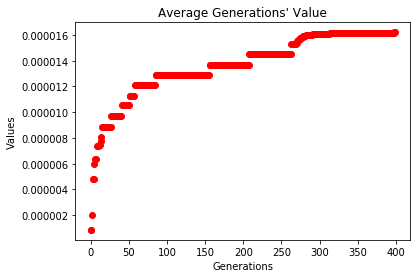

In [16]:
# now lets ask the user some questions to define problem's characteristics
want_sum = input("what's the summation? ")
want_sum = int(want_sum)
want_prod = input("what's the product? ")
want_prod = int(want_prod)

size = input("whats the size of the initial population? ")
size = int(size)
genes = input("how many genes in each chromosome? ")
genes = int(genes)
ask = input("do you want to have specific range of number of ones and zeros at the initialization stage? y or n? ")
if ask == 'y':
    onesMax = input("maximum number of ones? ")
    onesMin = input("minimum number of ones? ")
else:
    onesMax = 0
    onesMin = 0

pc = input("whats the crossover probability:pc? ")
pm = input("whats the mutation probability:pm? ")
pc = float(pc)
pm = float(pm)
generations = input("how many generations? ")
generations = int(generations)

population = np.zeros((size, genes))
values = np.zeros((int(size), 1))
numberOfCouples = 0

# first we create a random population
population = random_B_initialization(population, int(genes), int(size), int(onesMin), int(onesMax))
#print(population[:5,:], '\n')

# now we evaluate each person
values = evaluation(population, size)
#print(values)

maxVal = np.zeros((generations,1)) # here will the best chromosome's value of each generation will be stored
avgV = np.zeros((generations,1))
epochs = np.zeros((generations,1))

# now let's select some people for crossover
print("now the algorithm will implement k - ways tournament selection\n")
k = input("please select the k - ways\n ")
k = int(k)
x = 0
b = 0
index = 0

while (x < generations) and (maxVal[b] <= 0.95):
    couples = tournamentSelection(k, int(size))
    population_Crossover_Mutation_Selection(pc, pm)
    index, maxVal[x] = max(enumerate(values), key=operator.itemgetter(1))
    maxVal[x] = np.amax(values, axis=0)

    avgV[x] = avgValue(size)
    x += 1
    b = x - 1

print("the best string is: ", population[index])
#print("last values are ",values)
#print("last population is ",population)
print("the best solution found was ",evaluation(population[index], 1))


plt.figure(1)
plt.plot(avgV, 'ro')
plt.title("Average Generations' Value")
plt.xlabel('Generations')
plt.ylabel('Values')

plt.show()
